# Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Display properties
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML

# Date
import datetime
from datetime import date, timedelta


# Maps
from math import pi

import pickle 

from sklearn.preprocessing import StandardScaler
import mglearn

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
#Sklearn packages

# Import required packages for pre and post processing
from sklearn.preprocessing import normalize

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram



# Call Pickle

In [3]:
with open('fifa_processed.pkl', 'rb') as f:
    fifa = pickle.load(f)


In [4]:
with open('predictors_processed.pkl', 'rb') as f:
    predictors = pickle.load(f)


In [5]:
pd.__version__

'0.25.1'

---

## Models are being used in this part:

1. SVM_ONE CLASS
2. ISOLATION FOREST
3. LOCAL OUTLIER FACTOR


---

# Anomoly_Detection

## STEP 1: Preprocessing before running model

### Scale the data before running model


In [6]:
numeric_cols=['Age', 'Overall','Potential','Special','International Reputation', 'Weak Foot', 'Skill Moves',
               'Height', 'Weight','LS','ST','RS',  'LW',  'LF',  'CF',  'RF',  'RW',  'LAM',  'CAM',  'RAM', 
               'LM',  'LCM',  'CM',  'RCM',  'RM',  'LWB',  'LDM',  'CDM',  'RDM',  'RWB',  'LB',  'LCB',  'CB',
               'RCB',  'RB',  'Crossing',  'Finishing',  'HeadingAccuracy',  'ShortPassing',  'Volleys', 
               'Dribbling',  'Curve',  'FKAccuracy',  'LongPassing',  'BallControl',  'Acceleration',  
               'SprintSpeed',  'Agility',  'Reactions',  'Balance',  'ShotPower',  'Jumping',  'Stamina',  
               'Strength',  'LongShots',  'Aggression',  'Interceptions',  'Positioning',  'Vision',  
               'Penalties',  'Composure',  'Marking',  'StandingTackle',  'SlidingTackle',  'GKDiving',  
               'GKHandling',  'GKKicking',  'GKPositioning',  'GKReflexes',  'Club_Reputation',  
               'Position_Potential',  'Attacking',  'Skill',  'Movement',  'Power',  'Mentality',  
               'Defending',  'GoalKeeping',  'Potential_Difference',  'Attack_WR',  'Defense_WR']

non_numeric_cols=['Position_CAM',  'Position_CB',  'Position_CDM',  'Position_CF',  'Position_CM',  
                   'Position_GK',  'Position_LAM',  'Position_LB',  'Position_LCB',  'Position_LCM',  
                   'Position_LDM',  'Position_LF',  'Position_LM',  'Position_LS',  'Position_LW',  
                   'Position_LWB',  'Position_RAM',  'Position_RB',  'Position_RCB',  'Position_RCM',  
                   'Position_RDM',  'Position_RF',  'Position_RM',  'Position_RS',  'Position_RW',  
                   'Position_RWB',  'Position_ST',  'Continent_Africa',  'Continent_Asia',  'Continent_Europe',
                   'Continent_North America',  'Continent_Oceania',  'Continent_South America',  
                   'Position_Group_Defender',  'Position_Group_Forward',  'Position_Group_GoalKeeper', 
                   'Position_Group_Midfielder', 'Preferred Foot','Real Face','Body Type']
len(numeric_cols) + len(non_numeric_cols)

121

In [7]:
scl = StandardScaler()

#Scale the numeric columns
predictors_num = pd.DataFrame(scl.fit_transform(predictors[numeric_cols]), columns=numeric_cols)

#Merge scaled numerics with the dummy/ordinal columns
predictors_scaled = pd.concat([predictors_num,predictors[non_numeric_cols]], axis=1)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

recommendations = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(predictors_scaled)

In [9]:
def recommended_k_players_df(player, k_players = 100):
    #Find players' position group
    pos_group = list(fifa.Position_Group[fifa['Name']==player])[0]
    
    #Filter df for that position group
    if pos_group == 'Forward':
        indices = list(fifa[(fifa.Position_Group == 'Forward')|(fifa.Position_Group == 'Midfielder')].index.values)
    elif pos_group == 'Midfielder':
        indices = list(fifa[(fifa.Position_Group == 'Forward')|(fifa.Position_Group == 'Midfielder')].index.values)
    elif pos_group == 'Defender':
        indices = list(fifa[fifa.Position_Group == 'Defender'].index.values)
    elif pos_group == 'GoalKeeper':
        indices = list(fifa[fifa.Position_Group == 'GoalKeeper'].index.values)
    
    predictors_scaled_subset = predictors_scaled.iloc[indices,:]
    predictors_subset = predictors.iloc[indices,:]
    
    #Fit KNN for the k_players within that position group
    recommendations2 = NearestNeighbors(n_neighbors=k_players, algorithm='ball_tree').fit(predictors_scaled_subset)

    #Pass the player name from the dataset to the function and get 5 similar players as output
    player_indices2 = recommendations2.kneighbors(predictors_scaled_subset)[1]
    
    #Get player index
    fifa_subset = fifa.iloc[indices,:]
    index = fifa_subset[fifa_subset['Name']==player].index.tolist()[0]
    
    #Make variables global
    global recommend_list
    global recommended_df
    global recommended_names
    
    #Create recommended name list
    recommend_list = []
    #for i in player_indices2[index][1:]:
    #        recommend_list.append(fifa_subset.iloc[i]['Name'])
    
    
    #Get filtered df of recommended players
    recommended_df = predictors_subset.iloc[list(player_indices2[index][:]),:]
    recommend_list = list(fifa_subset.iloc[list(player_indices2[index][:]),:].ID)
    recommend_list.insert(0, index)
    
    recommended_names = fifa.Name[fifa.ID.isin(recommend_list)]
    
    return recommend_list, recommended_names,recommended_df



In [323]:
fifa[fifa.Name.str.contains('Turan')]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
1045,1045,A. Turan,31,Turkey,77,77,Medipol Başakşehir FK,7500000.0,120000.0,2094,1,3.0,4.0,4.0,Normal,1,CM,14.0,0,1,2,178,168,73,73,73,76,76,76,76,76,77,77,77,76,75,75,75,76,69,70,70,70,69,67,67,67,67,67,77.0,71.0,65.0,79.0,78.0,79.0,79.0,64.0,78.0,80.0,75.0,68.0,81.0,74.0,76.0,75.0,78.0,59.0,68.0,75.0,80.0,61.0,77.0,80.0,73.0,79.0,69.0,63.0,60.0,11.0,7.0,11.0,12.0,11.0,0.0,1.5,High,High,Midfielder,3,74.0,76.0,74.8,71.0,75.000000,64.000000,10.4,0,Asia
4496,4496,A. Turan,34,Turkey,71,71,Atiker Konyaspor,725000.0,11000.0,1543,1,1.0,3.0,2.0,Normal,0,CB,4.0,2313,0,2,185,179,49,49,49,48,49,49,49,48,50,50,50,50,56,56,56,50,59,65,65,65,59,60,70,70,70,60,57.0,22.0,73.0,65.0,21.0,57.0,28.0,42.0,63.0,58.0,35.0,33.0,34.0,72.0,43.0,62.0,62.0,33.0,76.0,44.0,73.0,72.0,35.0,45.0,62.0,61.0,72.0,74.0,65.0,10.0,13.0,13.0,16.0,13.0,1500000.0,1.0,Low,High,Defender,2,47.6,49.6,43.4,55.4,58.000000,70.333333,13.0,0,Asia
5392,5392,A. Turan,26,Turkey,70,72,Kayserispor,1800000.0,8000.0,1917,0,1.0,2.0,3.0,Stocky,0,LB,89.0,549,0,2,175,174,61,61,61,65,64,64,64,65,65,65,65,67,67,67,67,67,69,68,68,68,69,68,64,64,64,68,69.0,42.0,39.0,70.0,40.0,65.0,80.0,69.0,68.0,70.0,78.0,75.0,69.0,70.0,86.0,79.0,41.0,78.0,73.0,75.0,65.0,68.0,61.0,58.0,71.0,50.0,62.0,73.0,64.0,10.0,7.0,12.0,15.0,15.0,3600000.0,1.2,Medium,Medium,Defender,2,52.0,70.4,75.6,69.2,62.166667,66.333333,11.8,2,Asia


In [324]:
recommended_k_players_df('A. Turan', k_players=300)

([1045,
  1709,
  2242,
  2342,
  5655,
  2867,
  2501,
  3526,
  3404,
  4504,
  3958,
  6555,
  3416,
  5062,
  2652,
  2226,
  1609,
  1054,
  2306,
  4891,
  4124,
  1774,
  2247,
  2674,
  2473,
  3076,
  1887,
  2057,
  4744,
  1583,
  3732,
  2234,
  6179,
  2897,
  2928,
  2181,
  2795,
  3349,
  2088,
  5364,
  1363,
  3861,
  1989,
  3364,
  2622,
  4467,
  5542,
  5889,
  4160,
  2941,
  3319,
  3448,
  2326,
  6271,
  951,
  4724,
  4126,
  5604,
  2219,
  1836,
  4385,
  5036,
  1830,
  2250,
  2841,
  2564,
  4771,
  4025,
  1705,
  3552,
  4448,
  3132,
  3951,
  2994,
  4886,
  4008,
  2608,
  1748,
  1466,
  965,
  1497,
  3228,
  3332,
  3267,
  3039,
  957,
  1379,
  4327,
  1477,
  1672,
  1762,
  1891,
  3152,
  4344,
  902,
  1288,
  3926,
  4219,
  7315,
  2613,
  1474,
  4047,
  2197,
  2964,
  6605,
  2956,
  4054,
  3488,
  1933,
  1818,
  2244,
  5020,
  3097,
  1917,
  3463,
  6126,
  2053,
  1044,
  2399,
  1459,
  7278,
  1587,
  1182,
  2369,
  4797,
  42

In [325]:
value_cols = fifa[['Value', 'Wage','Release Clause']]
value_cols_name = ['Value', 'Wage','Release Clause']

In [326]:
fifa_recommend = fifa[fifa.ID.isin(recommend_list)]

anomaly_detection = fifa_recommend[['Value', 'Wage','Release Clause']]

In [327]:
anomaly_detection

,Value,Wage,Release Clause
638,15000000.0,20000.0,22100000.0
902,8500000.0,30000.0,17000000.0
911,4100000.0,23000.0,8600000.0
928,9000000.0,26000.0,0.0
951,4500000.0,10000.0,6300000.0
...,...,...,...
8120,825000.0,3000.0,1300000.0
8165,825000.0,5000.0,1600000.0
8251,900000.0,1000.0,1400000.0
8341,800000.0,4000.0,1200000.0


In [328]:
anomaly_detection_scaled = pd.DataFrame(scl.fit_transform(anomaly_detection), columns=value_cols_name)

---

# STEP 2: MODELING

## 1.`MODEL 1: SVM.ONECLASS`

In [329]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma=0.1)

clf.fit(anomaly_detection_scaled)
pred = clf.predict(anomaly_detection_scaled)

fifa_recommend['anomaly_svm']=pred
outliers=fifa_recommend.loc[fifa_recommend['anomaly_svm']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_recommend['anomaly_svm'].value_counts())

 1    296
-1      5
Name: anomaly_svm, dtype: int64


In [330]:
display(recommended_df)

,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
1709,34,75,75,1863,0,1.0,3.0,3.0,0,7.0,365,0,3,180,163,70,70,70,74,73,73,73,74,74,74,74,75,71,71,71,75,59,56,56,56,59,55,46,46,46,55,77.0,64.0,68.0,75.0,64.0,79.0,77.0,76.0,74.0,...,1.000000,2,69.6,76.4,74.6,65.4,62.166667,25.666667,10.0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2242,34,74,74,1798,1,1.0,4.0,3.0,0,7.0,365,0,3,180,163,67,67,67,72,71,71,71,72,72,72,72,72,67,67,67,72,56,53,53,53,56,52,44,44,44,52,74.0,61.0,51.0,72.0,55.0,77.0,83.0,75.0,61.0,...,1.000000,2,62.6,73.4,74.2,61.4,63.333333,24.666667,10.4,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2342,30,74,74,1850,0,1.0,4.0,4.0,0,7.0,365,0,3,183,170,70,70,70,72,72,72,72,72,73,73,73,72,70,70,70,72,57,57,57,57,57,54,48,48,48,54,74.0,57.0,71.0,75.0,55.0,74.0,81.0,76.0,73.0,...,1.000000,2,66.4,75.8,71.8,68.6,66.166667,22.666667,8.8,0,2,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5655,30,69,69,1790,1,1.0,3.0,3.0,0,10.0,725,0,3,178,170,67,67,67,69,70,70,70,69,70,70,70,69,67,67,67,69,56,56,56,56,56,53,49,49,49,53,63.0,70.0,58.0,72.0,61.0,71.0,72.0,70.0,68.0,...,1.035714,2,64.8,70.8,66.4,62.4,64.000000,35.333333,9.6,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2867,34,73,73,1804,1,1.0,3.0,3.0,0,18.0,365,0,3,175,161,71,71,71,71,72,72,72,71,72,72,72,70,65,65,65,70,52,50,50,50,52,48,42,42,42,48,62.0,74.0,67.0,73.0,73.0,70.0,71.0,60.0,62.0,...,1.000000,2,69.8,67.4,77.2,68.4,56.833333,23.000000,10.2,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,28,70,70,1814,1,1.0,3.0,3.0,0,19.0,362,0,5,170,154,69,69,69,68,69,69,69,68,68,68,68,67,61,61,61,67,53,51,51,51,53,51,48,48,48,51,55.0,72.0,62.0,66.0,72.0,71.0,61.0,63.0,52.0,...,1.000000,2,65.4,63.4,73.6,68.0,57.666667,37.333333,13.8,0,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
7853,34,67,67,1664,0,1.0,3.0,3.0,0,14.0,1650,0,1,183,159,66,66,66,67,67,67,67,67,66,66,66,66,60,60,60,66,50,46,46,46,50,47,40,40,40,47,59.0,70.0,55.0,64.0,66.0,69.0,70.0,47.0,54.0,...,1.080000,2,62.8,60.6,68.0,61.0,55.000000,28.000000,10.6,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
5155,29,70,70,1819,1,1.0,4.0,3.0,1,11.0,914,0,1,175,163,68,68,68,69,69,69,69,69,68,68,68,69,63,63,63,69,55,51,51,51,55,52,46,46,46,52,63.0,66.0,58.0,68.0,64.0,71.0,66.0,67.0,59.0,...,1.156250,2,63.8,66.6,78.6,72.2,52.166667,32.666667,11.4,0,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

In [331]:
fifa_recommend= fifa_recommend.rename(columns={"Release Clause": "ReleaseClause"}, errors="raise")

Text(0, 0.5, 'Wage')

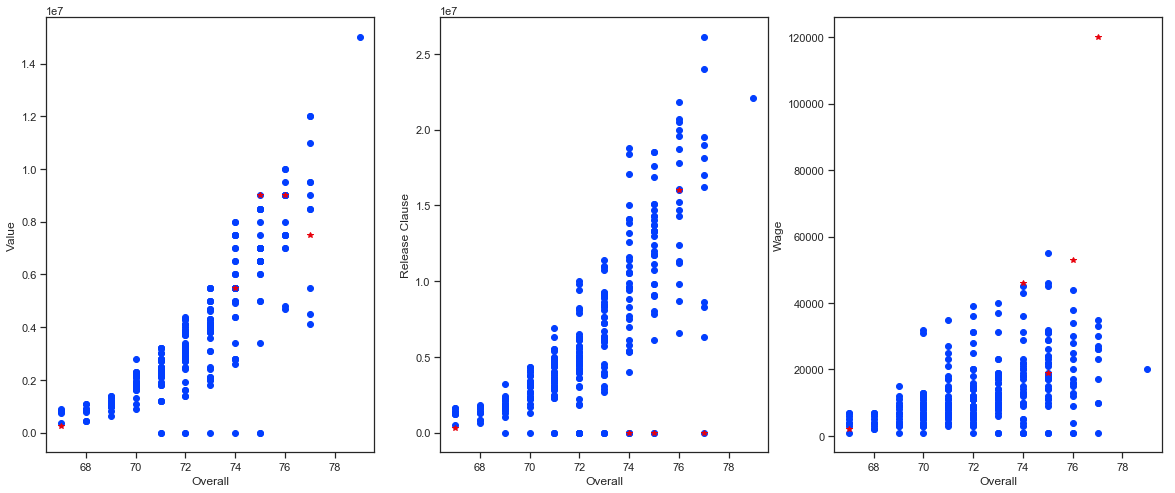

In [332]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_svm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_svm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_svm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_svm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_svm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_svm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_svm']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

In [333]:
fifa_recommend[fifa_recommend['anomaly_svm']==-1]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,ReleaseClause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
1045,1045,A. Turan,31,Turkey,77,77,Medipol Başakşehir FK,7500000.0,120000.0,2094,1,3.0,4.0,4.0,Normal,1,CM,14.0,0,1,2,178,168,73,73,73,76,76,76,76,76,77,77,77,76,75,75,75,76,69,70,70,70,69,67,67,67,67,67,77.0,71.0,65.0,79.0,78.0,79.0,79.0,64.0,78.0,80.0,75.0,68.0,81.0,74.0,76.0,75.0,78.0,59.0,68.0,75.0,80.0,61.0,77.0,80.0,73.0,79.0,69.0,63.0,60.0,11.0,7.0,11.0,12.0,11.0,0.0,1.500000,High,High,Midfielder,3,74.0,76.0,74.8,71.0,75.000000,64.000000,10.4,0,Asia,-1
1423,1423,V. Eysseric,26,France,76,77,Fiorentina,9000000.0,53000.0,1919,1,2.0,4.0,3.0,Normal,0,LW,7.0,510,0,3,180,161,71,71,71,75,74,74,74,75,76,76,76,75,71,71,71,75,59,59,59,59,59,55,50,50,50,55,82.0,70.0,52.0,79.0,70.0,79.0,76.0,78.0,76.0,79.0,69.0,69.0,76.0,70.0,69.0,74.0,58.0,60.0,64.0,76.0,66.0,34.0,76.0,78.0,70.0,70.0,60.0,32.0,26.0,9.0,13.0,10.0,11.0,8.0,16000000.0,1.291667,Medium,Medium,Forward,2,70.6,77.6,70.6,66.4,65.666667,39.333333,10.2,1,Europe,-1
1578,1578,Ivi,24,Spain,75,81,Real Valladolid CF,9000000.0,19000.0,1910,1,1.0,3.0,3.0,Normal,1,LM,7.0,0,1,1,175,163,73,73,73,75,74,74,74,75,73,73,73,74,68,68,68,74,60,56,56,56,60,56,50,50,50,56,72.0,75.0,59.0,71.0,66.0,81.0,57.0,66.0,65.0,77.0,81.0,80.0,78.0,71.0,82.0,77.0,69.0,68.0,64.0,76.0,49.0,41.0,72.0,66.0,73.0,63.0,50.0,36.0,29.0,13.0,15.0,12.0,7.0,12.0,0.0,1.066667,Medium,Medium,Midfielder,2,68.6,69.2,78.4,70.8,60.666667,38.333333,11.8,6,Europe,-1
2585,2585,A. Ragusa,28,Italy,74,74,Hellas Verona,5500000.0,46000.0,1868,1,1.0,3.0,4.0,Normal,0,LW,9.0,0,1,1,183,172,70,70,70,74,72,72,72,74,72,72,72,73,66,66,66,73,60,57,57,57,60,57,52,52,52,57,68.0,66.0,59.0,75.0,70.0,77.0,63.0,51.0,60.0,77.0,87.0,88.0,82.0,69.0,74.0,68.0,66.0,72.0,65.0,69.0,57.0,36.0,70.0,64.0,58.0,71.0,55.0,40.0,26.0,15.0,10.0,10.0,13.0,8.0,0.0,1.034483,High,Medium,Forward,2,67.6,65.6,80.0,68.0,59.333333,40.333333,11.2,0,Europe,-1
8635,8635,S. Ishizaki,36,Sweden,67,67,IF Elfsborg,240000.0,2000.0,1813,1,1.0,3.0,3.0,Normal,0,RM,24.0,358,0,1,180,179,63,63,63,66,65,65,65,66,67,67,67,67,66,66,66,67,59,59,59,59,59,56,54,54,54,56,72.0,59.0,48.0,69.0,66.0,68.0,74.0,69.0,71.0,70.0,64.0,57.0,73.0,68.0,72.0,66.0,60.0,61.0,69.0,68.0,43.0,43.0,66.0,69.0,68.0,69.0,65.0,51.0,38.0,6.0,13.0,6.0,10.0,11.0,300000.0,1.037037,Medium,Medium,Midfielder,2,62.8,70.4,66.8,64.8,59.666667,51.333333,9.2,0,Europe,-1


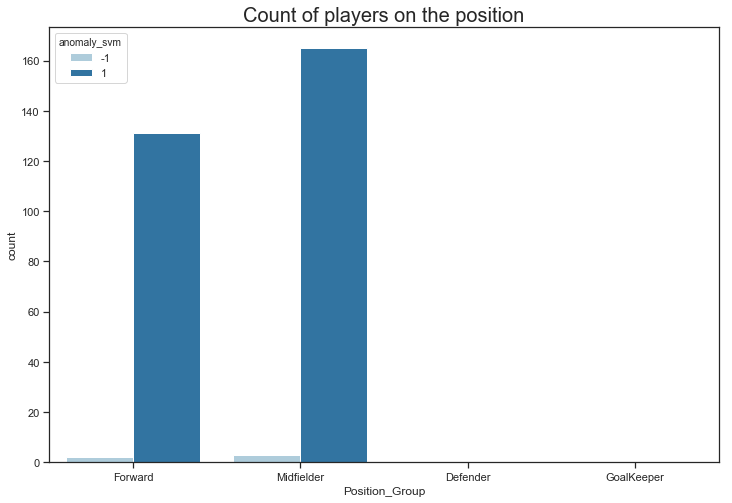

In [334]:
f, ax = plt.subplots(figsize=(12, 8))

ax = sns.countplot(x = 'Position_Group', data = fifa_recommend,
                   order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper'], hue = 'anomaly_svm',palette="Paired")

ax.set_title(label='Count of players on the position', fontsize=20);

---

## 2.`MODEL 2: ISOLATION FOREST`

The term isolation means ‘separating an instance from the rest of the instances’. Since anomalies are ‘few and different’ and therefore they are more susceptible to isolation. In a data-induced random tree, partitioning of instances are repeated recursively until all instances are isolated. This random partitioning produces noticeable  shorter paths for anomalies since the fewer instances of anomalies result in a smaller number of partitions – shorter paths in a tree structure, and instances with distinguishable attribute-values are more likely to be separated in early partitioning. Hence, when a forest of random trees collectively produce **shorter path lengths** for some particular points, then they are **highly likely to be anomalies**. 

The forest part comes in when a bunch of these decision trees are created and the scores are averaged, which gives a good idea about which observations are truly anomalies. As a result, Isolation Forests are used for outlier and anomaly detection.

**SUMMARY  HOW IT WORKS:**

Few and different to be isolated quicker

● For each tree:

    ○ Get a sample of the data
    ○ Randomly select a dimension
    ○ Randomly pick a value in that dimension
    ○ Draw a straight line through the data at that
      value and split data
    ○ Repeat until tree is complete
    
● Generate multiple trees → forest

● Anomalies will be isolated in only a few steps

● Nominal points in more

In [335]:
from sklearn.ensemble import IsolationForest

clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=119, verbose=0)
clf.fit(anomaly_detection_scaled)
pred = clf.predict(anomaly_detection_scaled)
fifa_recommend['anomaly_if']=pred
outliers=fifa_recommend.loc[fifa_recommend['anomaly_if']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_recommend['anomaly_if'].value_counts())

 1    265
-1     36
Name: anomaly_if, dtype: int64


/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



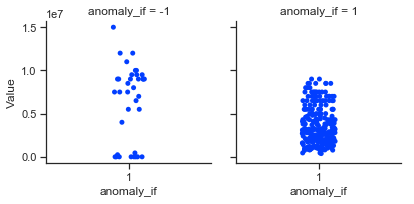

In [336]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_recommend, col="anomaly_if")

g.map(sns.stripplot, 'anomaly_if' ,"Value" )

Text(0, 0.5, 'Wage')

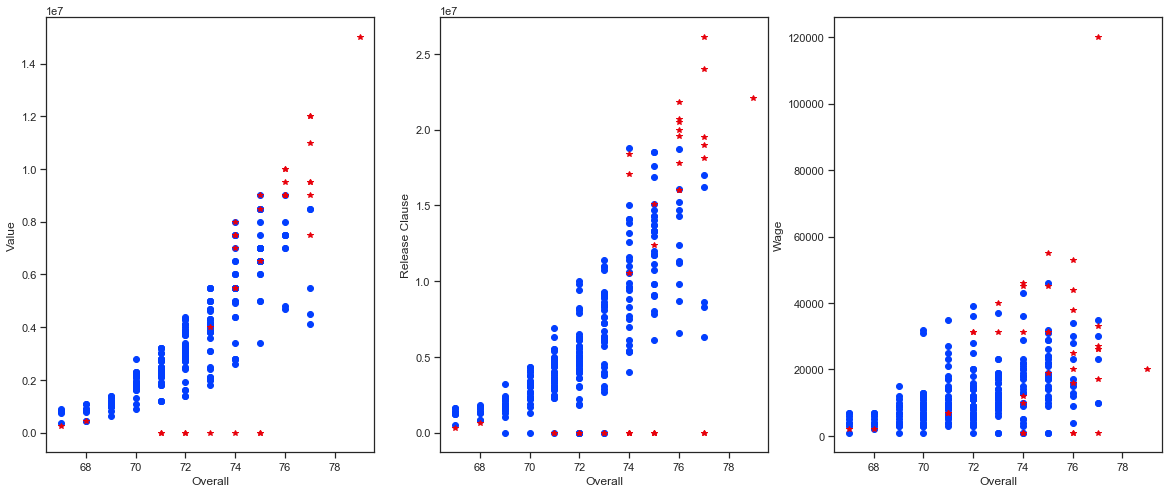

In [337]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

Text(0, 0.5, 'Wage')

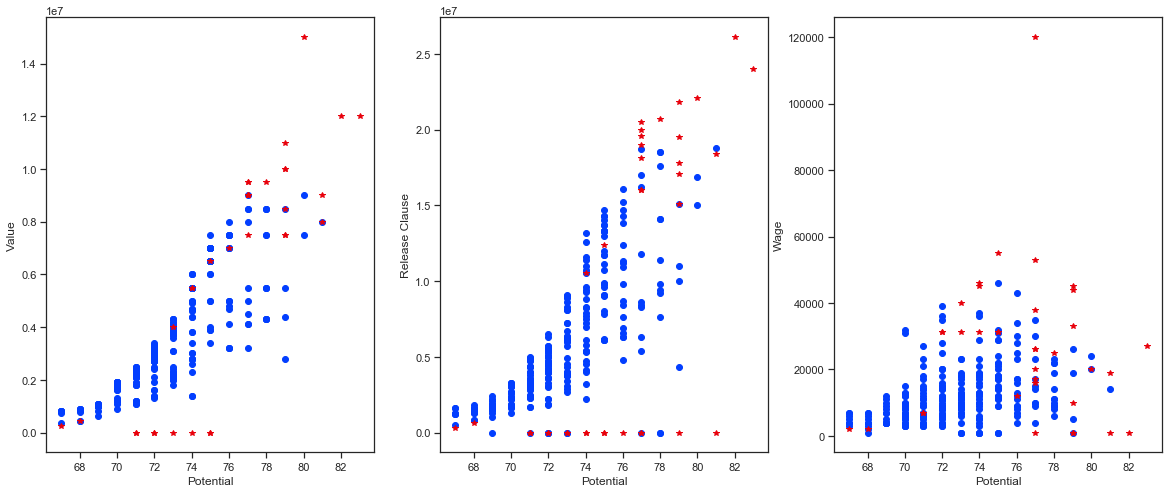

In [338]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==-1].Value,'r*')
ax[0].set_xlabel('Potential')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Potential')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Potential,fifa_recommend[fifa_recommend['anomaly_if']==-1].Wage,'r*')
ax[2].set_xlabel('Potential')
ax[2].set_ylabel('Wage')

---

## 3.`MODEL 3: LOCAL OUTLIER FACTOR`

### `Model 3.1: Manhattan distance`

In [339]:
from sklearn.neighbors import LocalOutlierFactor

In [340]:
clf = LocalOutlierFactor(n_neighbors=2,metric='manhattan')
pred_of = clf.fit_predict(anomaly_detection_scaled)
scores = clf.negative_outlier_factor_
scores_of = -scores # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [341]:
print(scores_of.min())
print(scores_of.max())
print(scores_of.mean())
print(scores_of.std())

0.7053996016497296
6.098090631365798
1.2273622443598644
0.5232148465209344


In [342]:
fifa_recommend['scores_ofm'] = scores_of

fifa_recommend.loc[fifa_recommend.scores_ofm < scores_of.mean()+scores_of.std(), 'anomaly_ofm'] = 1
fifa_recommend.loc[fifa_recommend.scores_ofm >= scores_of.mean()+scores_of.std(), 'anomaly_ofm'] = -1

outliers=fifa_recommend.loc[fifa_recommend['anomaly_ofm']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_recommend['anomaly_ofm'].value_counts())

 1.0    271
-1.0     30
Name: anomaly_ofm, dtype: int64


Text(0, 0.5, 'Wage')

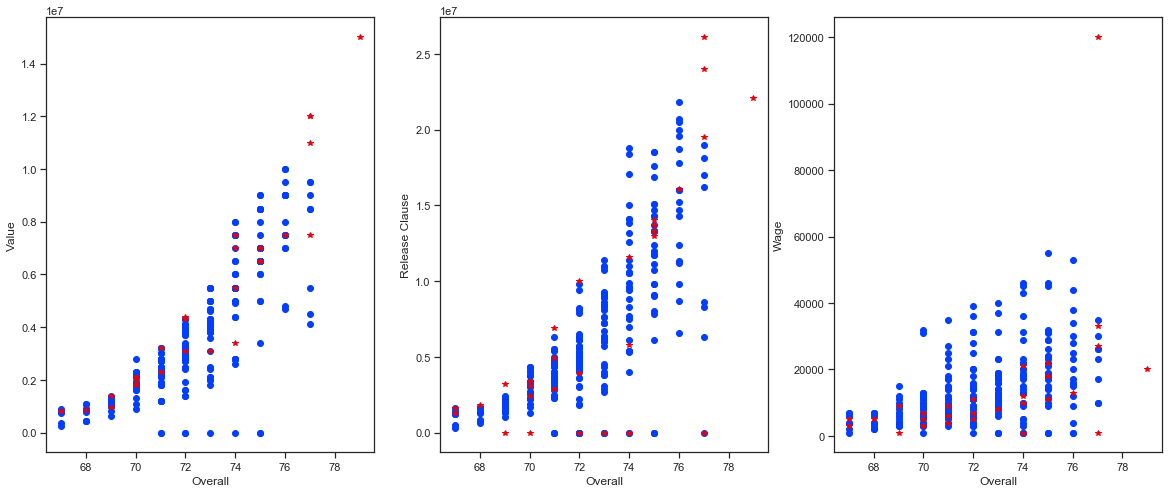

In [343]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofm']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofm']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



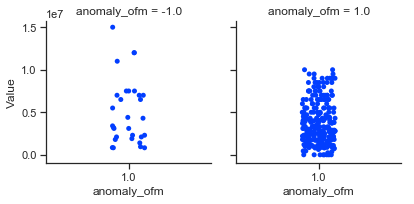

In [344]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_recommend, col="anomaly_ofm")

g.map(sns.stripplot, 'anomaly_ofm' ,"Value")

---

### `Model 3.2: Euclidean distance`

In [345]:
clf = LocalOutlierFactor(n_neighbors=2,metric='euclidean')
pred_of = clf.fit_predict(anomaly_detection_scaled)
scores = clf.negative_outlier_factor_
scores_of = -scores # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [346]:
fifa_recommend['scores_ofe'] = scores_of

fifa_recommend.loc[fifa_recommend.scores_ofm < scores_of.mean()+scores_of.std(), 'anomaly_ofe'] = 1
fifa_recommend.loc[fifa_recommend.scores_ofm >= scores_of.mean()+scores_of.std(), 'anomaly_ofe'] = -1

outliers=fifa_recommend.loc[fifa_recommend['anomaly_ofe']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_recommend['anomaly_ofe'].value_counts())

 1.0    271
-1.0     30
Name: anomaly_ofe, dtype: int64


/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



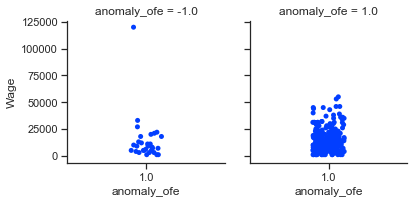

In [347]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_recommend, col="anomaly_ofe")

g.map(sns.stripplot, 'anomaly_ofe' ,"Wage" )

Text(0, 0.5, 'Wage')

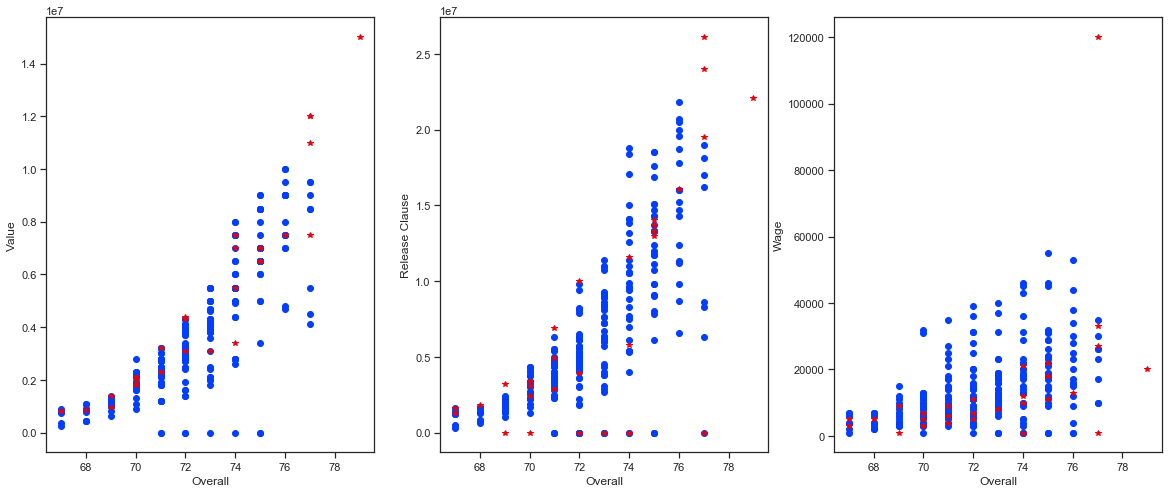

In [348]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofe']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofe']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

---

### `MODEL 3.3 - USING COSINE DISTANCE`

In [349]:
clf = LocalOutlierFactor(n_neighbors=2,metric='cosine')
pred_of = clf.fit_predict(anomaly_detection_scaled)
scores = clf.negative_outlier_factor_
scores_of = -scores # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [350]:
fifa_recommend['scores_ofc'] = scores_of

fifa_recommend.loc[fifa_recommend.scores_ofm < scores_of.mean(), 'anomaly_ofc'] = 1
fifa_recommend.loc[fifa_recommend.scores_ofm >= scores_of.mean(), 'anomaly_ofc'] = -1

outliers=fifa_recommend.loc[fifa_recommend['anomaly_ofc']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_recommend['anomaly_ofc'].value_counts())

1.0    301
Name: anomaly_ofc, dtype: int64


/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



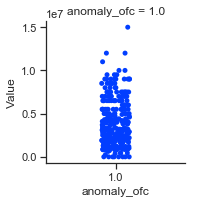

In [351]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_recommend, col="anomaly_ofc")

g.map(sns.stripplot, 'anomaly_ofc' ,"Value" )

Text(0, 0.5, 'Wage')

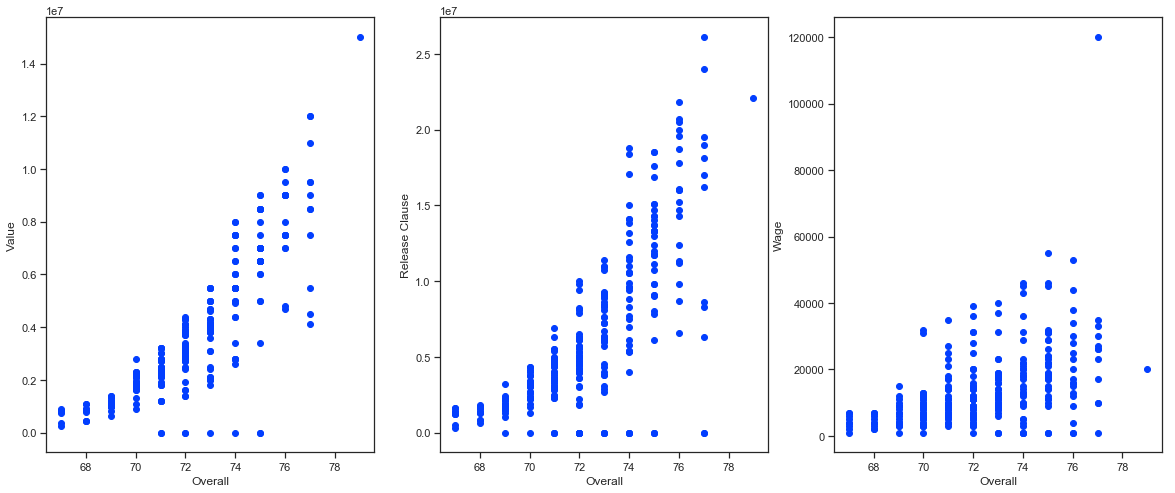

In [352]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_ofc']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_ofc']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

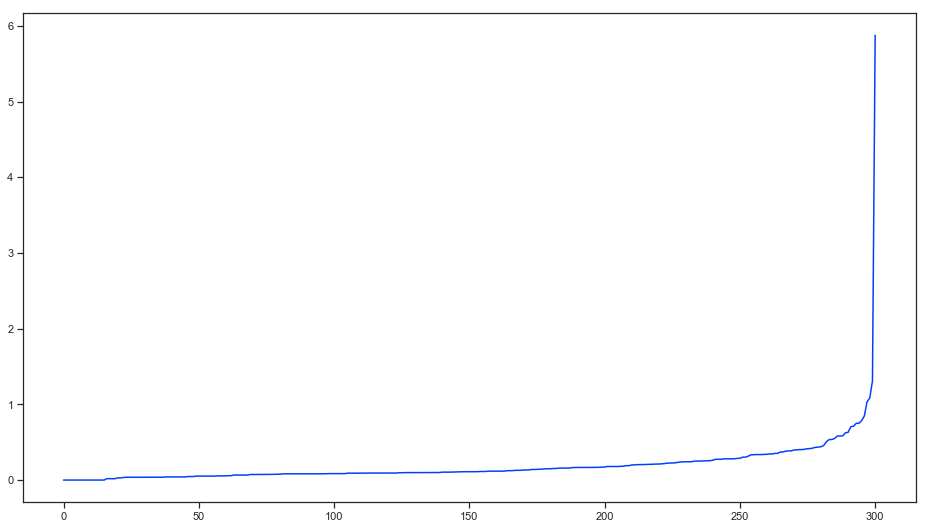

In [353]:
# Define the most appropriate eps, using KNN
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(anomaly_detection_scaled)
distances, indices = nbrs.kneighbors(anomaly_detection_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [354]:
y = range(1, len(fifa_recommend)+1)

import sys
sys.path.append('..')

from kneed import KneeLocator

kn = KneeLocator(list(distances),y,curve='concave', direction='increasing')
kn.knee

0.4573400588588191

In [355]:
import math
math.log(len(fifa_recommend))

5.707110264748875

In [356]:
from sklearn.cluster import DBSCAN
import mglearn
plt.rcParams['figure.figsize'] = (16, 9)

dbsc = DBSCAN(eps= kn.knee, min_samples = math.log(len(fifa_recommend))).fit(anomaly_detection_scaled)
#clusters = dbscan.fit_predict(X_scaled)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True


In [357]:
labels

array([-1, -1,  0, -1,  0,  1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0,  0,
        1, -1, -1, -1,  0, -1, -1,  1,  0, -1,  0,  0,  1, -1, -1, -1, -1,
       -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1, -1,  1,  0, -1, -1,
        0,  0,  0,  0,  0,  1, -1,  0,  2, -1,  2,  0,  1, -1,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0, -1,  2, -1,  1, -1,  0, -1,  0, -1,  0,  0, -1, -1, -1,  0, -1,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  2,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  2,  0,  0,  2,  0,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0

In [358]:
fifa_recommend['anomaly_dbscan'] = labels
fifa_recommend['anomaly_dbscan'] = fifa_recommend['anomaly_dbscan'].astype('int')

Text(0, 0.5, 'Wage')

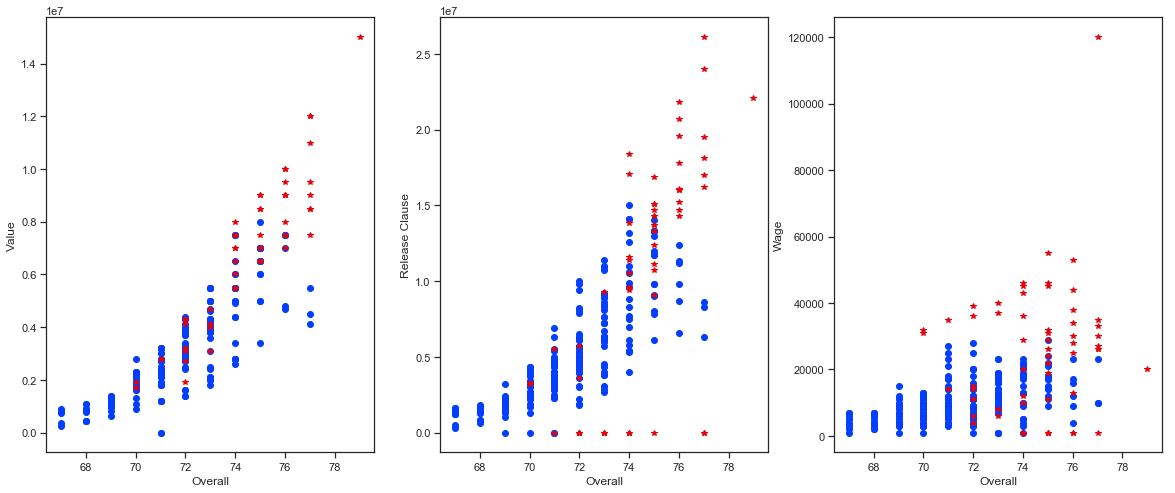

In [359]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

Text(0, 0.5, 'Wage')

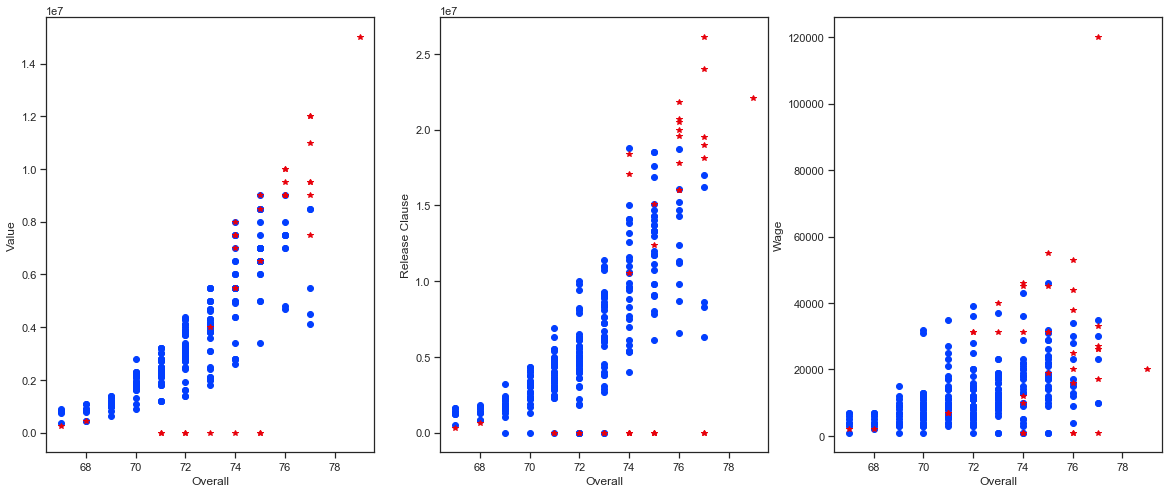

In [360]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].ReleaseClause,'r*')
ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_if']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_if']==-1].Wage,'r*')
ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

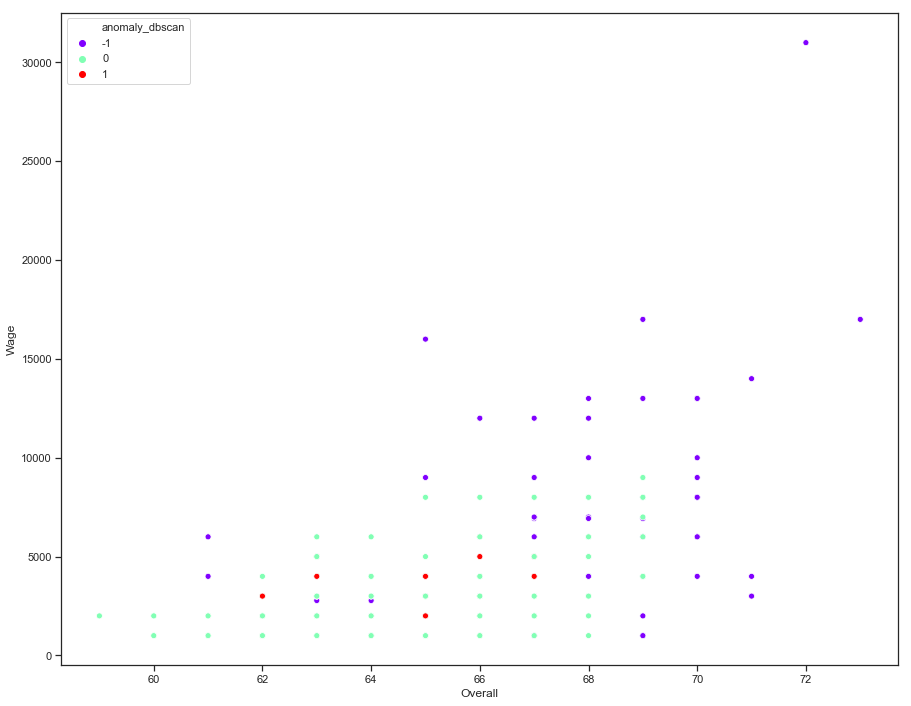

In [320]:
plt.figure(figsize = (15,12))

sns.scatterplot('Overall', 'Wage', data=fifa_recommend, hue = 'anomaly_dbscan', palette='rainbow', legend = 'full')

Text(0, 0.5, 'Wage')

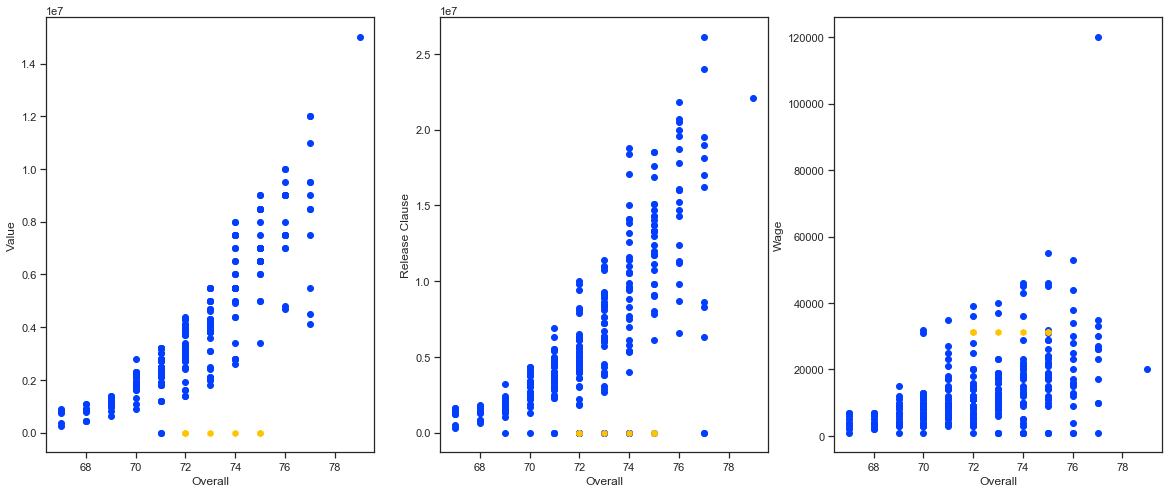

In [362]:
fig, ax = plt.subplots(nrows = 1, ncols = 3 ,figsize = (20,8))
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Value,'bo')
ax[0].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==2].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==2].Value,'yh')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].ReleaseClause,'bo')
ax[1].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==2].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==2].ReleaseClause,'yh')


ax[1].set_xlabel('Overall')
ax[1].set_ylabel('Release Clause')

ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==-1].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==0].Wage,'bo')
ax[2].plot(fifa_recommend[fifa_recommend['anomaly_dbscan']==2].Overall,fifa_recommend[fifa_recommend['anomaly_dbscan']==2].Wage,'yh')


ax[2].set_xlabel('Overall')
ax[2].set_ylabel('Wage')

In [364]:
fifa_recommend[fifa_recommend['anomaly_if']==-1].sort_values(by=['Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,...,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,ReleaseClause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if,scores_ofm,anomaly_ofm,scores_ofe,anomaly_ofe,scores_ofc,anomaly_ofc,anomaly_dbscan
638,638,S. Berghuis,26,Netherlands,79,80,Feyenoord,15000000.0,20000.0,1953,0,2.0,3.0,3.0,Lean,1,RW,19.0,519,0,3,183,159,73,73,73,78,77,77,77,78,78,78,78,77,73,73,73,77,60,58,58,58,60,56,47,47,47,56,79.0,...,76.0,82.0,80.0,75.0,82.0,76.0,70.0,82.0,53.0,72.0,58.0,83.0,63.0,37.0,75.0,76.0,70.0,73.0,34.0,36.0,30.0,9.0,11.0,7.0,7.0,15.0,22100000.0,1.178571,Medium,Medium,Forward,2,70.4,80.0,76.6,69.6,65.666667,33.333333,9.8,1,Europe,1,-1,2.834097,-1.0,1.665488,-1.0,1.087686,1.0,-1
986,986,A. Miranchuk,22,Russia,77,82,Lokomotiv Moscow,12000000.0,1000.0,1780,0,1.0,2.0,3.0,Lean,0,CAM,15.0,2375,0,3,183,163,69,69,69,74,73,73,73,74,75,75,75,74,71,71,71,74,57,55,55,55,57,53,44,44,44,53,65.0,...,71.0,79.0,71.0,75.0,77.0,74.0,67.0,65.0,58.0,74.0,64.0,65.0,43.0,36.0,72.0,80.0,57.0,70.0,22.0,28.0,29.0,8.0,8.0,9.0,12.0,15.0,26100000.0,1.464286,Medium,Medium,Midfielder,2,65.2,69.0,72.8,65.2,59.666667,26.333333,10.4,5,Europe,1,-1,1.875542,-1.0,1.861429,-1.0,0.901174,1.0,-1
1054,1054,R. De Paul,24,Argentina,77,83,Udinese,12000000.0,27000.0,1908,1,1.0,3.0,4.0,Normal,0,LW,16.0,888,0,5,178,154,72,72,72,76,76,76,76,76,76,76,76,76,72,72,72,76,60,57,57,57,60,56,48,48,48,56,76.0,...,72.0,81.0,78.0,74.0,78.0,72.0,72.0,78.0,58.0,70.0,68.0,79.0,56.0,28.0,75.0,75.0,70.0,76.0,24.0,44.0,40.0,13.0,12.0,10.0,7.0,14.0,24000000.0,1.200000,Medium,Medium,Forward,2,65.8,76.8,74.8,70.6,63.333333,36.000000,11.2,6,South America,1,-1,2.000792,-1.0,1.764941,-1.0,1.195679,1.0,-1
1044,1044,V. Grifo,25,Italy,77,79,TSG 1899 Hoffenheim,11000000.0,33000.0,1918,1,1.0,2.0,4.0,Normal,0,LM,23.0,184,0,4,180,165,71,71,71,76,75,75,75,76,75,75,75,75,70,70,70,75,61,58,58,58,61,57,49,49,49,57,82.0,...,63.0,84.0,74.0,66.0,78.0,72.0,79.0,81.0,52.0,72.0,62.0,76.0,52.0,45.0,73.0,70.0,65.0,72.0,50.0,31.0,30.0,10.0,12.0,8.0,8.0,14.0,19500000.0,1.363636,Medium,Medium,Midfielder,2,68.8,78.8,73.8,68.6,62.833333,37.000000,10.4,2,Europe,1,-1,2.346325,-1.0,2.029645,-1.0,1.135106,1.0,-1
1288,1288,F. Di Francesco,24,Italy,76,79,Sassuolo,10000000.0,44000.0,1878,1,1.0,4.0,4.0,Lean,0,LW,34.0,180,0,3,170,165,69,69,69,76,74,74,74,76,75,75,75,76,70,70,70,76,62,58,58,58,62,58,48,48,48,58,77.0,...,67.0,82.0,82.0,83.0,79.0,72.0,77.0,74.0,44.0,76.0,65.0,70.0,42.0,34.0,74.0,68.0,69.0,74.0,48.0,38.0,36.0,11.0,10.0,6.0,10.0,5.0,17800000.0,1.333333,Medium,Medium,Forward,2,65.2,75.8,78.6,65.8,60.166667,40.666667,8.4,3,Europe,1,-1,1.498997,1.0,1.448702,1.0,1.414653,1.0,-1
1470,1470,D. Pelkas,24,Greece,76,79,PAOK,10000000.0,1000.0,1855,1,1.0,3.0,4.0,Lean,0,LM,18.0,2375,0,3,178,161,68,68,68,74,73,73,73,74,74,74,74,73,69,69,69,73,57,54,54,54,57,53,43,43,43,53,70.0,...,73.0,76.0,83.0,78.0,81.0,66.0,84.0,74.0,48.0,68.0,44.0,76.0,39.0,31.0,72.0,76.0,67.0,72.0,47.0,30.0,26.0,11.0,15.0,11.0,10.0,16.0,21800000.0,1.074074,High,Medium,Midfielder,2,65.8,74.6,78.4,62.0,59.500000,34.333333,12.6,3,Europe,1,-1,1.311562,1.0,1.282107,1.0,1.156982,1.0,-1
957,957,Wilson Eduardo,27,Portugal,77,77,SC Braga,9500000.0,17000.0,1928,1,1.0,3.0,4.0,Normal,0,RS,7.0,1219,0,2,178,161,76,76,76,76,77,77,77,76,75,75,75,75,69,69,69,75,56,53,53,53,56,52,46,46,46,52,75.0,...,63.0

In [371]:
abnormal_players = fifa_recommend[fifa_recommend['anomaly_if']==-1]

In [373]:
abnormal_players.loc[abnormal_players.Value < fifa_recommend.Value.describe()[5], 'UnderValue'] = 1
abnormal_players.loc[abnormal_players.Value >= fifa_recommend.Value.describe()[5], 'UnderValue'] = 0

In [378]:
abnormal_players[abnormal_players['UnderValue'] == 1]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,...,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,ReleaseClause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if,scores_ofm,anomaly_ofm,scores_ofe,anomaly_ofe,scores_ofc,anomaly_ofc,anomaly_dbscan,UnderValue
1902,1902,C. Cueva,26,Peru,75,75,No_Club,0.0,31214.0,1849,1,1.0,4.0,3.0,Normal,0,LM,8.0,0,0,0,168,134,69,69,69,74,73,73,73,74,73,73,73,73,68,68,68,73,60,57,57,57,60,57,48,48,48,57,70.0,...,76.0,84.0,83.0,81.0,74.0,82.0,70.0,67.0,63.0,48.0,64.0,48.0,49.0,74.0,69.0,67.0,60.0,44.0,32.0,31.0,8.0,10.0,7.0,10.0,11.0,0.0,1.062241,Medium,Medium,Midfielder,2,63.4,71.2,80.8,62.4,61.166667,35.666667,9.2,0,South America,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
1933,1933,K. Traoré,26,Ivory Coast,75,75,No_Club,0.0,31214.0,1815,0,1.0,3.0,4.0,Normal,0,CAM,8.0,0,0,0,178,165,67,67,67,73,72,72,72,73,74,74,74,73,69,69,69,73,57,56,56,56,57,54,45,45,45,54,66.0,...,76.0,81.0,72.0,82.0,74.0,67.0,55.0,51.0,71.0,54.0,62.0,57.0,41.0,77.0,76.0,71.0,78.0,26.0,33.0,32.0,13.0,8.0,10.0,9.0,10.0,0.0,1.062241,High,Low,Midfielder,2,63.2,73.4,75.2,58.6,66.666667,30.333333,10.0,0,Africa,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
2399,2399,K. Konaté,26,Ivory Coast,74,74,No_Club,0.0,31214.0,1938,1,1.0,4.0,3.0,Normal,0,RW,11.0,0,0,0,178,165,72,72,72,74,73,73,73,74,72,72,72,73,67,67,67,73,59,55,55,55,59,56,48,48,48,56,70.0,...,73.0,88.0,87.0,85.0,74.0,76.0,80.0,64.0,77.0,60.0,72.0,62.0,40.0,74.0,63.0,67.0,67.0,24.0,35.0,33.0,12.0,12.0,13.0,15.0,13.0,0.0,1.062241,High,Medium,Forward,2,69.6,72.8,82.0,70.6,62.166667,30.666667,13.0,0,Africa,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
2724,2724,C. Keşerü,31,Romania,73,73,No_Club,0.0,31214.0,1839,0,2.0,3.0,2.0,Normal,0,CAM,13.0,0,0,0,178,157,72,72,72,68,70,70,70,68,68,68,68,68,64,64,64,68,56,53,53,53,56,53,48,48,48,53,67.0,...,66.0,73.0,65.0,59.0,76.0,78.0,80.0,64.0,72.0,72.0,69.0,40.0,47.0,79.0,69.0,75.0,70.0,32.0,32.0,28.0,14.0,10.0,12.0,8.0,12.0,0.0,1.062241,High,Medium,Midfielder,2,69.6,65.0,70.2,71.4,63.333333,30.666667,11.2,0,Europe,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
3625,3625,R. Varga,28,Hungary,72,72,No_Club,0.0,31214.0,1857,1,1.0,4.0,3.0,Lean,0,RW,17.0,0,0,0,183,174,71,71,71,72,71,71,71,72,70,70,70,71,63,63,63,71,54,50,50,50,54,51,46,46,46,51,70.0,...,72.0,85.0,82.0,74.0,68.0,69.0,71.0,81.0,72.0,68.0,69.0,62.0,25.0,75.0,69.0,63.0,73.0,34.0,28.0,18.0,15.0,13.0,9.0,11.0,10.0,0.0,1.062241,Medium,Medium,Forward,2,68.2,69.0,75.6,72.2,61.166667,26.666667,11.6,0,Europe,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
3710,3710,Y. Ouattara,34,Ivory Coast,72,72,No_Club,0.0,31214.0,1816,0,1.0,5.0,3.0,Normal,0,RW,16.0,0,0,0,175,157,67,67,67,71,70,70,70,71,70,70,70,71,63,63,63,71,54,49,49,49,54,50,39,39,39,50,72.0,...,71.0,87.0,74.0,86.0,69.0,83.0,74.0,58.0,71.0,57.0,61.0,42.0,32.0,73.0,63.0,73.0,72.0,17.0,28.0,21.0,8.0,15.0,15.0,13.0,8.0,0.0,1.062241,High,Medium,Forward,2,65.6,72.0,79.8,64.2,59.166667,22.000000,11.8,0,Africa,1,-1,1.000000,1.0,1.000000,1.0,1.000000,1.0,2,1.0
4121,4121,J. Campos,30,Bolivia,71,71,No_Club,0.0,6927.0,1744,0,1.0,3.0,3.0,Lean,0,CAM,10.0,0,0,0,175,141,63,63,63,68,67,67,67,68,69,69,69,68,65,65,65,68,51,49,49,49,51,46,37,37,37,46,64.0,...,78.0,66.0,64.0,71.0,63.0,79.0,68.0,57.0,78.0,62.0,74.0,39.0,29.0,61.0,72.0,81.0,64.0,10.0,21.0,23.0,9.0,16.0,15.0,10.0,7.0,0.0,1.062241,Medium,Low,Midfield

In [379]:
with open('abnormal_players.pkl', 'wb') as f:
    pickle.dump(abnormal_players, f)

---

## Gaussian Random Projection

In [136]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 121
eps = None
random_state = 218

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

predictors_scaled_GRP = GRP.fit_transform(predictors_scaled)
predictors_scaled_GRP = pd.DataFrame(data=predictors_scaled_GRP, index=predictors_scaled.index)

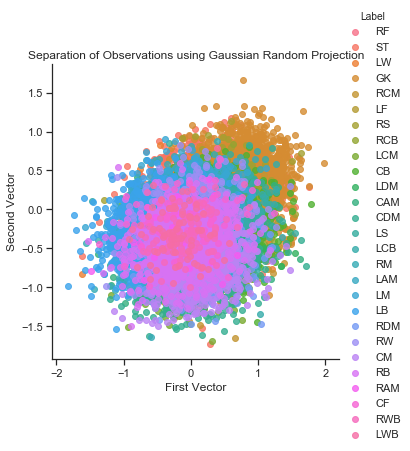

In [137]:
scatterPlot(predictors_scaled_GRP, fifa.Position, "Gaussian Random Projection")

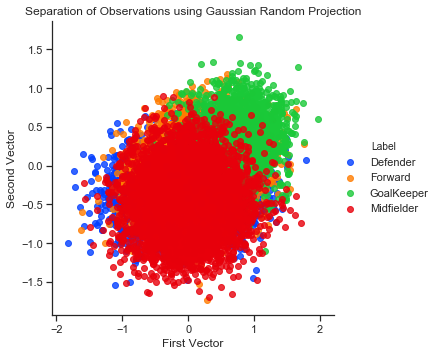

In [138]:
scatterPlot(predictors_scaled_GRP, fifa.Position_Group, "Gaussian Random Projection")

---

## SparseRandomProjection

In [85]:
from sklearn.random_projection import SparseRandomProjection

n_components = 121
density = 'auto'
eps = .01
dense_output = True
random_state = 218

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

predictors_SRP = SRP.fit_transform(anomaly_scaled)
predictors_SRP = pd.DataFrame(data=predictors_SRP, index=anomaly_scaled.index)


In [324]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

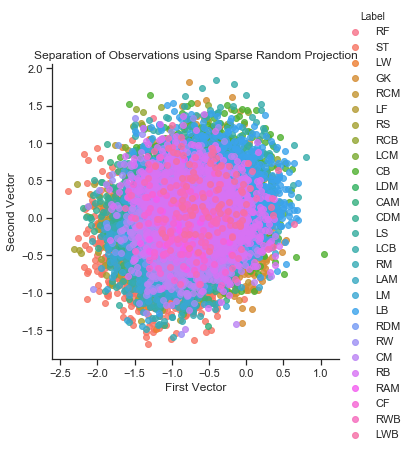

In [87]:
scatterPlot(predictors_SRP, fifa.Position, "Sparse Random Projection")

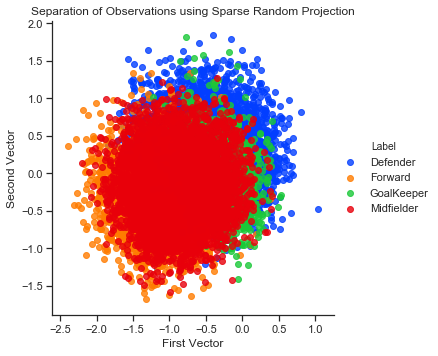

In [88]:
scatterPlot(predictors_SRP, fifa.Position_Group, "Sparse Random Projection")

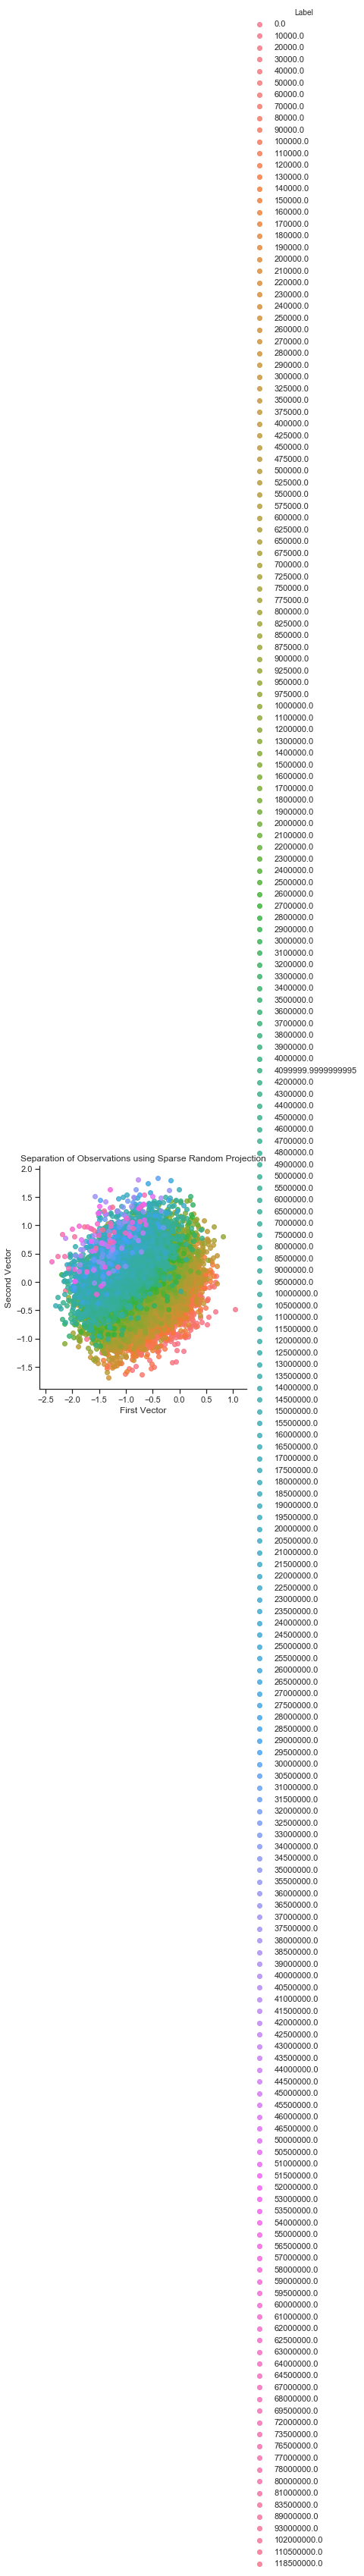

In [90]:
scatterPlot(predictors_SRP, target_val, "Sparse Random Projection")

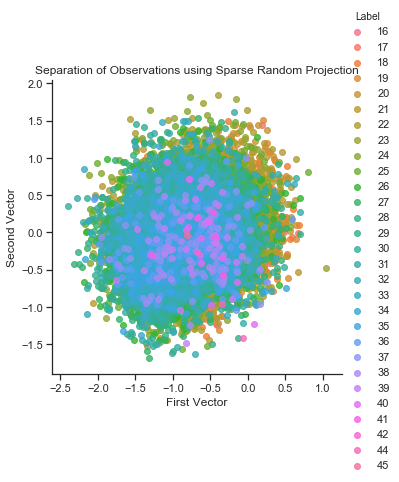

In [89]:
scatterPlot(predictors_SRP, fifa.Age, "Sparse Random Projection")

---

## MiniBatchDictionaryLearning

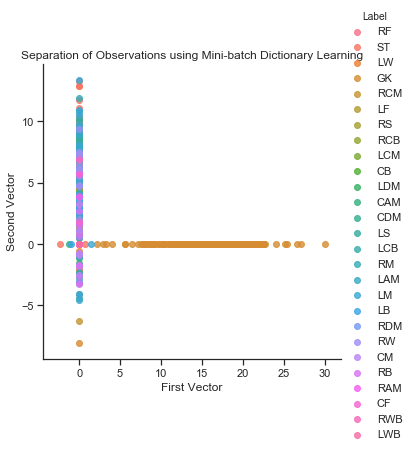

In [91]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 121
alpha = 1
batch_size = 100
n_iter = 10
random_state = 218

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(anomaly_scaled)
predictors_scaled_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(anomaly_scaled)
predictors_scaled_miniBatchDictLearning = \
    pd.DataFrame(data=predictors_scaled_miniBatchDictLearning, index=anomaly_scaled.index)

scatterPlot(predictors_scaled_miniBatchDictLearning, fifa.Position, \
            "Mini-batch Dictionary Learning")

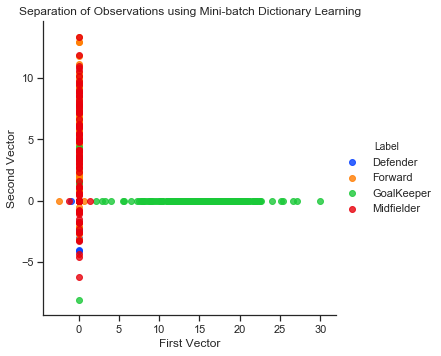

In [92]:
scatterPlot(predictors_scaled_miniBatchDictLearning, fifa.Position_Group, \
            "Mini-batch Dictionary Learning")